# Notebook I - Climate Regime
<hr>
This module performs climate data analysis and compiling general agro-climatic indicators. These general agro-climatic indicators summarize climatic profiles in the study area for each grid. The key input data for this module is the climatic data, and the geographical and terrain data.

Prepared by Geoinformatics Center, AIT
<hr>


### Google drive connection
In this step, we will connect to Google Drive service and mount the drive where we will start our PyAEZ project

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

Then, installing any additional python packages that required to run PyAEZ.
If working on your own PC/machine, these additional installation will vary depending on what is already installed in your Python library. 

In [ ]:
# 'Installing neccessary packages'
# !pip install gdal
# # !pip install pyaez==2.0.0

Now, we will import the specific Python packages we need for PyAEZ.

In [1]:
'''import supporting libraries'''
import numpy as np
import matplotlib.pyplot as plt
import os
# try:
#     from osgeo import gdal
# except:
#     import gdal
    
from osgeo import gdal
import sys
from time import time as timer

# because I saved our data in nc files
# import xarray as xr

Setting the working directory -- where our PyAEZ project is located.

In [2]:
# branch version tag
revname='v2'

# 'Set the working directory'

# HPC Orion
# Replace with path to your PyAEZ folder under your username
work_dir = '/work/hpc/users/kerrie/UN_FAO/repos/PyAEZ/'

# Replace with whatever location you want to output data under your username
out_path = '/work/hpc/users/kerrie/UN_FAO/pyaez_results/global_1980/'+revname+'/' 

# these are the same for everyone on HPC Orion
# data_dir = '/work/hpc/datasets/un_fao/pyaez/global_1980/daily/netcdf/'
data_dir = '/work/hpc/datasets/un_fao/pyaez/global_1980/daily/npy/'
maskfile = '/work/hpc/datasets/un_fao/pyaez/static/netcdf/mask_2268708_5m.nc'
elevfile = '/work/hpc/datasets/un_fao/pyaez/static/netcdf/Elevation_2268708_5m.nc'

os.chdir(work_dir)
sys.path.append('./pyaez/')

# Check whether the specified path exists or not
isExist = os.path.exists(out_path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(out_path)
   print("The new directory is created!")


<hr>

## MODULE 1: CLIMATE REGIME
Now, we will start executing the routines in Module 1


First, we initiate Module 1 Class instance by invoking the following commands:

In [3]:
# Import Module 1 and initate Class intance
from pyaez import ClimateRegime
clim_reg = ClimateRegime.ClimateRegime()

# Importing UtilitiesCalc
from pyaez import UtilitiesCalc
obj_utilities = UtilitiesCalc.UtilitiesCalc()



### Importing the climate dataset and the geographical data/rasters.

The package expects six climate variables, as daily or monthly observations, as Numpy arrays.
Arrays must be 3-dimensional, with the third axes containing the time dimension.
Unit of measures are expected as follows:
- Minimum temperature = Degree Celsius
- Maximum temperature = Degree Celsius
- Precipitation = Accumulated mm / day (or per month)
- Solar radiation = W/m$^2$
- Wind speed = Average m/s
- Relative humidity = Average fraction (0 to 1)

In addition to climate data, the system requires:
- A binary admin_mask, with 0 and 1 values. 0 pixels values will be not executed, while 1 pixels values will be executed
- An elevation layer
- Soil/terrain/special land cover classes
  

**All the datasets must have the same shape.**

In [4]:
# Importing the climate data
max_temp = np.load(data_dir+'Tmax-2m/0.npy')  # maximum temperature
min_temp = np.load(data_dir+'Tmin-2m/0.npy')  # minimum temperature
precipitation = np.load(data_dir+'Precip/0.npy')  # precipitation
rel_humidity = np.load(data_dir+'Rhum/0.npy')  # relative humidity
wind_speed = np.load(data_dir+'Wind-2m/0.npy') # wind speed measured at two meters
short_rad = np.load(data_dir+'Srad/0.npy')  # shortwave radiation

# Load the geographical data/rasters
mask=np.load(data_dir+'mask/0.npy')
elevation=np.load(data_dir+'Elevation/0.npy')
# soil_terrain_lulc = gdal.Open(r'./data_input/LAO_soil_terrain_lulc.tif').ReadAsArray()

print(min_temp.shape)

(2160, 4320, 366)


This section contains parameters that can be modified by the user:
- lat_min = minimum latitude of analysis
- lat_max = maximum latitude of analysis
- mask_value = the value in the admin_mask to exclude from the analysis (typically 0)
- daily = whether climate input data are daily (True) or monthly (False)

In [5]:
# Define the Area-Of-Interest's geographical extents
lat_min = 13.87
lat_max = 22.59
mask_path=maskfile
mask_value = 0  # pixel value in admin_mask to exclude from the analysis
daily = True #Type of climate data = True: daily, False: monthly

### Loading the imported data into the Object Class ('*clim_reg*' Class)

In [6]:
clim_reg.setStudyAreaMask(mask, mask_value)
clim_reg.setLocationTerrainData(lat_min, lat_max, elevation)
if daily:
    clim_reg.setDailyClimateData(
        min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)
else:
    clim_reg.setMonthlyClimateData(
        min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)

In [7]:
'Releasing the memory of input climate data -- free up some RAM space'
del(min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity)

In [8]:
clim_reg.__dict__.keys()

dict_keys(['im_mask', 'nodata_val', 'set_mask', 'elevation', 'im_height', 'im_width', 'latitude', 'meanT_daily', 'totalPrec_daily', 'pet_daily', 'maxT_daily', 'meanT_daily_sealevel', 'P_by_PET_daily'])

NOTE: After loading the data into the *clim_reg* Class, all the parameters will be converted to DAILY DATA and calculated as other parameters. 
These new parameters are available and can be called into use as:
- *clim_reg.minT_daily* (minimum temperature)
- *clim_reg.maxT_daily* (maximum temperature)
- *clim_reg.meanT_daily* (mean temperature)
- *clim_reg.meanT_daily_sealevel* (mean temperature, corrected to sea-level)
- *clim_reg.totalPrec_daily* (total precipitation)
- *clim_reg.pet_daily* (reference evapotranspiration, ETo)
- *clim_reg.P_by_PET_daily* (ratio of precipitation over ETo)
  


#### Thermal Climate
The Thermal Climate function calculates and classifies latitudinal thermal climate, which will be used later in Module 2 for the assessment of potential crops and land utilization types (LUT) presence in each grid cell.

/work/hpc/users/kerrie/UN_FAO/env_pyaez/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


FileNotFoundError: [Errno 2] No such file or directory: './data_output/NB1/LAO_ThermalClimate.png'

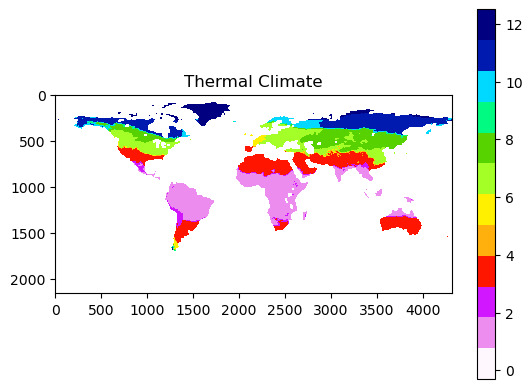

In [9]:
tclimate = clim_reg.getThermalClimate()

In [ ]:
'''save and visualize result'''
fig = plt.figure()
plt.imshow(tclimate, cmap=plt.get_cmap('gist_ncar_r', 12),vmin=-0.3,vmax=12.5)
plt.title('Thermal Climate')
plt.colorbar()
plt.savefig(out_path+"ThermalClimate.png",bbox_inches ="tight",dpi=300) #Save as PNG image
# plt.savefig("./data_output/NB1/LAO_ThermalClimate.png",bbox_inches ="tight",dpi=300) #Save as PNG image
plt.show()

obj_utilities.saveRaster(mask_path, out_path+'ThermalClimate_'+revname+'.tif',tclimate) #Save as GeoTIFF raster
# obj_utilities.saveRaster(mask_path, './data_output/NB1/LAO_ThermalClimate.tif',tclimate) #Save as GeoTIFF raster

#### Thermal Zone
The thermal zone is classified based on actual temperature which reflects on the temperature regimes of major thermal climates

In [ ]:
tzone = clim_reg.getThermalZone()

'''save and visualize result'''
fig = plt.figure()
plt.imshow(tzone, cmap=plt.get_cmap('gist_ncar_r', 12),vmin=-0.3,vmax=12.5)
plt.title('Thermal Zones')
plt.colorbar()
plt.savefig("./data_output/NB1/LAO_ThermalZone.png",bbox_inches ="tight",dpi=300) #Save as PNG image
plt.show()

obj_utilities.saveRaster(mask_path, './data_output/NB1/LAO_ThermalZone.tif',tzone) #Save as GeoTIFF raster

#### Thermal Length of Growing Period (LGP)
The thermal length of growing period (LGPt) is defined as the number of days in a year during which the daily mean temperature (Ta) is conductive to crop growth and development. PyAEZ utilizes the AEZ three standard temperature thresholds for LGPt:
- Periods with Ta>0°C (LGPt0)
- Periods with Ta>5°C (LGPt5) – the period conductive to plant growth and development
- Periods, and Ta>10°C (LGPt10) – a proxy for the period of low risks for late and early frost occurrences and termed ‘frost-free period’

In [ ]:
lgpt0 = clim_reg.getThermalLGP0()
lgpt5 = clim_reg.getThermalLGP5()
lgpt10 = clim_reg.getThermalLGP10()

In [ ]:
'''save and visualize result'''
#======================
plt.figure(1, figsize=(24, 8))
plt.subplot(1, 3, 1)
plt.imshow(lgpt0,vmin=0,vmax=366)
plt.title('LGPt 0')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 2)
plt.imshow(lgpt5, vmin=0, vmax=366)
plt.title('LGPt 5')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 3)
plt.imshow(lgpt10, vmin=0, vmax=366)
plt.title('LGPt 10')
plt.colorbar(shrink=0.8)
#----------------------
plt.savefig("./data_output/NB1/LAO_ThermalLGPs.png",
            bbox_inches="tight", dpi=300)
plt.show()
#======================

obj_utilities.saveRaster(mask_path, './data_output/NB1/LAO_LGPt0.tif', lgpt0)
obj_utilities.saveRaster(mask_path, './data_output/NB1/LAO_LGPt5.tif', lgpt5)
obj_utilities.saveRaster(mask_path, './data_output/NB1/LAO_LGPt10.tif', lgpt10)


#### Temperature Sum

In [ ]:
tsum0 = clim_reg.getTemperatureSum0()
tsum5 = clim_reg.getTemperatureSum5()
tsum10 = clim_reg.getTemperatureSum10()

In [ ]:
'''save and visualize result'''
#======================
plt.figure(1, figsize=(24, 8))
plt.subplot(1, 3, 1)
plt.imshow(tsum0, cmap='hot_r', vmin=0, vmax=11000)
plt.title('T-sumation 0')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 2)
plt.imshow(tsum5, cmap='hot_r', vmin=0, vmax=11000)
plt.title('T-sumation 5')
plt.colorbar(shrink=0.8)
#----------------------
plt.subplot(1, 3, 3)
plt.imshow(tsum10, cmap='hot_r', vmin=0, vmax=11000)
plt.title('T-sumation 10')
plt.colorbar(shrink=0.8)
#----------------------
plt.savefig("./data_output/NB1/LAO_Tsum.png",
            bbox_inches="tight", dpi=300)
plt.show()
#======================

obj_utilities.saveRaster(mask_path, './data_output/NB1/LAO_tsum0.tif', tsum0)
obj_utilities.saveRaster(mask_path, './data_output/NB1/LAO_tsum5.tif', tsum5)
obj_utilities.saveRaster(mask_path, './data_output/NB1/LAO_tsum10.tif', tsum10)


#### Temperature Profile

In [ ]:
tprofile = clim_reg.getTemperatureProfile()

In [ ]:
'''save and visualize result'''

tile_list = ['A9', 'A8', 'A7', 'A6', 'A5', 'A4', 'A3', 'A2',
             'A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']

fig = plt.figure(figsize=(12, 20))
for i1 in range(1, 19):
    plt.subplot(6, 3, i1)
    plt.imshow(tprofile[i1-1])
    plt.title(tile_list[i1-1])
    plt.colorbar(shrink=0.9)
plt.tight_layout()

plt.savefig("./data_output/NB1/LAO_Tprofiles.png",
            bbox_inches="tight", dpi=300)
plt.show()

for i1 in range(18):
    obj_utilities.saveRaster(
        mask_path, './data_output/NB1/LAO_TProfile_' + tile_list[i1] + '.tif', tprofile[i1])
    

#### Length of Growing Periods (LGPs)

In [ ]:
lgp = clim_reg.getLGP( Sa = 100 )
lgp_class = clim_reg.getLGPClassified(lgp)
lgp_equv = clim_reg.getLGPEquivalent()

In [ ]:
'''save and visualize result'''

plt.imshow(lgp, cmap='viridis', vmin=0, vmax=366)
plt.title('LPG [days]')
plt.colorbar()
plt.savefig("./data_output/NB1/LAO_LGP.png", bbox_inches="tight", dpi=300)
plt.show()


plt.imshow(lgp_equv, cmap='viridis', vmin=0, vmax=366)
plt.title('LPG Equivalent [days]')
plt.colorbar()
plt.savefig("./data_output/NB1/LAO_LGP_Equv.png",
            bbox_inches="tight", dpi=300)
plt.show()

obj_utilities.saveRaster(mask_path, './data_output/NB1/LAO_LGP.tif', lgp)

obj_utilities.saveRaster(mask_path, './data_output/NB1/LAO_LGPEquivalent.tif', lgp_equv)


#### Multi Cropping Zone
Multiple cropping zones classification is an additional agro-climatic indicator, which relates to the possibility of cultivating multiple sequential crops under rain-fed and irrigated conditions.

In [ ]:
multi_crop = clim_reg.getMultiCroppingZones(tclimate, lgp, lgpt5, lgpt10, tsum0, tsum10)
multi_crop_rainfed = multi_crop[0]  # for rainfed conditions
multi_crop_irr = multi_crop[1]  # for irrigated conditions


In [ ]:
'''save and visualize result'''

plt.imshow(multi_crop_irr, cmap=plt.get_cmap('gist_ncar_r', 9), vmin=-0.2, vmax=8.4)
plt.title('Multi Cropping Zone - IRR')
plt.colorbar()
plt.savefig("./data_output/NB1/LAO_multicrop_irr.png", bbox_inches="tight", dpi=300)
plt.show()
obj_utilities.saveRaster(
    mask_path, './data_output/NB1/LAO_multicrop_irr.tif', multi_crop_irr)


plt.imshow(multi_crop_rainfed,cmap=plt.get_cmap('gist_ncar_r', 9), vmin=-0.2, vmax=8.4)
plt.title('Multi Cropping Zone - RAINFED')
plt.colorbar()
plt.savefig("./data_output/NB1/LAO_multicrop_rain.png",bbox_inches="tight", dpi=300)
plt.show()
obj_utilities.saveRaster(
    mask_path, './data_output/NB1/LAO_multicrop_rain.tif', multi_crop_rainfed)


### Air Frost Index and Permafrost Evaluation
Occurrence of continuous or discontinuous permafrost conditions are used in the suitability assessment. Permafrost areas are characterized by sub-soil at or below the freezing point for two or more years. In this section, PyAEZ utilizes the air frost index (FI) which is used to characterize climate-derived permafrost condition into 4 classes: 
1) Continuous permafrost
2) Discontinuous permafrost 
3) Sporadic permafrost
4) No permafrost

In [ ]:
permafrost_eval = clim_reg.AirFrostIndexandPermafrostEvaluation()
frost_index = permafrost_eval[0]
permafrost = permafrost_eval[1]

In [ ]:
'''save and visualize result'''

plt.imshow(frost_index, cmap=plt.get_cmap(
    'tab20b', 11), vmin=-0.05, vmax=1.05)
plt.title('Frost Index')
plt.colorbar()
plt.savefig("./data_output/NB1/LAO_frost_index.png",
            bbox_inches="tight", dpi=300)
plt.show()
obj_utilities.saveRaster(
    mask_path, './data_output/NB1/LAO_frost_index.tif', frost_index)



plt.imshow(permafrost, cmap=plt.get_cmap(
    'tab20b', 5), vmin=-0.5, vmax=4.3)
plt.title('Permafrost Evaluation')
plt.colorbar()
plt.savefig("./data_output/NB1/LAO_permafrost.png",
            bbox_inches="tight", dpi=300)
plt.show()
obj_utilities.saveRaster(
    mask_path, './data_output/NB1/LAO_permafrost.tif', permafrost)


### Fallow period requirement
Fallow is an agricultural technique that consists of not sowing the arable land during one or more growing seasons. In AEZ framework, the fallow factors have been established by main crop groups and environmental conditions. The crop groups include cereals, legumes, roots and tubers, and a miscellaneous group consisting of long-term annuals/perennials. The fallow factors are expressed as percentage of time during the fallow-cropping cycle the land must be under fallow. PyAEZ determines the fallow requirements using Thermal Zones.

In [ ]:
tzone_fallow = clim_reg.TZoneFallowRequirement(tzone)

'''save and visualize result'''
fig = plt.figure()
plt.imshow(tzone_fallow, cmap=plt.get_cmap('tab10', 7), vmin=-0.5, vmax=6.3)
plt.title('Fallow Requirement')
plt.colorbar()
plt.savefig("./data_output/NB1/LAO_fallow.png",
            bbox_inches="tight", dpi=300)
plt.show()
obj_utilities.saveRaster(
    mask_path, './data_output/NB1/LAO_fallow.tif', tzone_fallow)


### Agro-ecological zones classification
The agro-ecological zones (AEZ) methodology provides a framework for establishing a spatial inventory of land resources compiled from global/national environmental data sets and assembled to quantify multiple spatial characteristics required for the assessments of land productivity under location-specific agro-ecological conditions.

In [ ]:
aez = clim_reg.AEZClassification(
    tclimate, lgp, lgp_equv, lgpt5, soil_terrain_lulc, permafrost)

# now visualizing result
fig = plt.figure()
plt.imshow(aez, cmap=plt.get_cmap('rainbow', 59), vmin=0, vmax=59)
plt.title('Agro-ecological Zonation')
plt.colorbar()
plt.savefig("./data_output/NB1/LAO_aez.png",
            bbox_inches="tight", dpi=300)
plt.show()
obj_utilities.saveRaster(
    mask_path, './data_output/NB1/LAO_aez.tif', aez)


<hr>

### END OF MODULE 1: CLIMATE REGIME

<hr>